In [60]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

url = "https://www.kaggle.com/api/v1/datasets/download/srijan1upadhyay/startup-valuation-dataset"

response = requests.get(url, allow_redirects=True)
if response.status_code == 200:
    print("Download completed ✅")
else:
    raise Exception(f"failed download: {response.status_code}")

zip_file = zipfile.ZipFile(io.BytesIO(response.content))
print("Archivos en el zip:", zip_file.namelist())

csv_filename = zip_file.namelist()[0]

df = pd.read_csv(zip_file.open(csv_filename))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("rows for model:", len(df))




Download completed ✅
Archivos en el zip: ['startup_valuation_dataset.csv']
rows for model: 50000


Data Analysis

Basic exploration data


In [2]:
df.columns

Index(['startup_id', 'startup_name', 'founded_year', 'country', 'region',
       'industry', 'funding_round', 'funding_amount_usd', 'funding_date',
       'lead_investor', 'co_investors', 'employee_count',
       'estimated_revenue_usd', 'estimated_valuation_usd', 'exited',
       'exit_type', 'tags'],
      dtype='object')

In [29]:
df.shape

(50000, 17)

In [3]:
round(df.describe(),2)

,founded_year,funding_amount_usd,employee_count,estimated_revenue_usd,estimated_valuation_usd
count,49950,49950,49950,49950,49950
mean,2014,811842965,502,223212830,4887317283
std,5,1273332522,289,401527746,8276942494
min,2005,3925000,2,622017,12794686
25%,2009,210187750,252,45549718,1092665221
50%,2014,439775000,503,106864489,2441790700
75%,2019,926249750,752,245513627,5465277689
max,2023,61037115000,1000,23041887506,322060497842


In [ ]:
df.dtypes

startup_id                  object
startup_name                object
founded_year                 int64
country                     object
region                      object
industry                    object
funding_round               object
funding_amount_usd           int64
funding_date                object
lead_investor               object
co_investors                object
employee_count               int64
estimated_revenue_usd      float64
estimated_valuation_usd    float64
exited                        bool
exit_type                   object
tags                        object
dtype: object

In [3]:
df.sample(5)

,startup_id,startup_name,founded_year,country,region,industry,funding_round,funding_amount_usd,funding_date,lead_investor,co_investors,employee_count,estimated_revenue_usd,estimated_valuation_usd,exited,exit_type,tags
19051,8652aa09-6620-4faa-99be-62d78ae76fbd,Rodriguez PLC,2019,San Marino,Oceania,E-commerce,Series A,891450000,2021-08-09,Sequoia,Sequoia,781,1.169860e+08,6.559881e+09,False,NaN,"EdTech, B2B"
3706,b23c7da8-941e-4791-88d9-43679c6e7503,"Moses, Simmons and Beard",2016,Brunei Darussalam,Asia,Fintech,Series A,1047033000,2020-11-07,Andreessen Horowitz,"Index Ventures, SoftBank",893,5.214475e+08,2.735854e+09,False,NaN,"B2B, HealthTech, Mobile"
27395,2a208293-f2d2-4cf5-9744-7d6062282bea,Nelson Group,2017,Kuwait,Europe,E-commerce,Series A,372793000,2023-09-06,Andreessen Horowitz,"Andreessen Horowitz, Sequoia, Y Combinator",16,1.523906e+08,1.856506e+09,False,NaN,"IoT, AI, EdTech, Cloud"
4088,685e30fe-52d5-40be-b5bb-04e1e1efd6b7,Nelson Ltd,2009,Falkland Islands (Malvinas),Europe,Blockchain,Series B,1826743000,2015-09-18,Tiger Global,"Accel, Tiger Global, Andreessen Horowitz",998,1.602306e+08,6.002175e+09,False,NaN,"AI, Mobile, Cloud, EdTech"
13661,ac5c378a-144a-4399-83d9-24c7439470e2,"Wright, Jackson and Brown",2019,Tuvalu,Asia,Healthcare,Series C,211197000,2016-04-05,Y Combinator,Y Combinator,563,1.053940e+08,1.732043e+09,False,NaN,"Marketplace, AI, SaaS"


In [61]:
df = df.drop(['country','startup_name','startup_id','lead_investor','tags'], axis=1) 

In [25]:
df.shape

(50000, 12)

In [62]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

def preprocess_startup_data(df, top_n_tags=None):
    """
    Limpia y transforma el dataset de startups:
    - Convierte columnas monetarias a float
    - Procesa columnas de fecha (día, mes, año, etc.)
    - Convierte co_investors en cantidad total de inversores
    - Separa y codifica tags (one-hot, opcionalmente limitando a top N)
    - One-hot encoding para variables categóricas
    - Elimina columnas irrelevantes
    """
    df = df.copy()

    # 1. Limpieza de montos en USD
    cash_cols = ['funding_amount_usd', 'estimated_revenue_usd', 'estimated_valuation_usd']
    for col in cash_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

    # 2. Procesamiento de fechas
    if 'funding_date' in df.columns:
        df['funding_date'] = pd.to_datetime(df['funding_date'], errors='coerce')
        df['funding_date_day'] = df['funding_date'].dt.day.fillna(0).astype('int32')
        df['funding_date_month'] = df['funding_date'].dt.month.fillna(0).astype('int32')
        df['funding_date_year'] = df['funding_date'].dt.year.fillna(0).astype('int32')
        df['funding_date_weekday'] = df['funding_date'].dt.weekday.fillna(0).astype('int32')
        df['funding_date_quarter'] = df['funding_date'].dt.quarter.fillna(0).astype('int32')
        df.drop(columns=['funding_date'], inplace=True)

    # 3. Procesar co_investors → convertir a número de inversores
    if 'co_investors' in df.columns:
        df['co_investors'] = df['co_investors'].fillna('')
        df['co_investors_count'] = df['co_investors'].apply(
            lambda x: len([i.strip() for i in x.split(',') if i.strip() != ''])
        )
        df.drop(columns=['co_investors'], inplace=True)

    # 4. Procesar tags con one-hot encoding (o top N)
    # if 'tags' in df.columns:
    #     df['tags'] = df['tags'].fillna('').apply(lambda x: [t.strip() for t in x.split(',') if t.strip() != ''])
    #     if top_n_tags is not None:
    #         # Limitar a los N tags más frecuentes
    #         all_tags = df['tags'].explode()
    #         top_tags = [t for t, _ in Counter(all_tags).most_common(top_n_tags)]
    #         for t in top_tags:
    #             df[f"tag_{t}"] = df['tags'].apply(lambda tags_list: int(t in tags_list))
    #     else:
    #         # One-hot para todos los tags
    #         mlb_tags = MultiLabelBinarizer()
    #         tags_encoded = pd.DataFrame(
    #             mlb_tags.fit_transform(df['tags']),
    #             columns=[f"tag_{t}" for t in mlb_tags.classes_],
    #             index=df.index
    #         )
    #         df = pd.concat([df, tags_encoded], axis=1)
    #     df.drop(columns=['tags'], inplace=True)

    # 5. One-hot encoding para variables categóricas simples
    categorical_cols = [
        'region', 'industry', 'funding_round',
        'lead_investor','exit_type','exited'
    ]
    existing_cats = [c for c in categorical_cols if c in df.columns]
    df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

    # 7. Asegurar tipos numéricos
    for col in df.select_dtypes(include='object').columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        except:
            pass

    return df


In [63]:
df=preprocess_startup_data(df)


In [8]:
lista=list()
for x in df.columns:
    lista.append(x)
lista    

['founded_year',
 'funding_amount_usd',
 'employee_count',
 'estimated_revenue_usd',
 'estimated_valuation_usd',
 'funding_date_day',
 'funding_date_month',
 'funding_date_year',
 'funding_date_weekday',
 'funding_date_quarter',
 'co_investors_count',
 'tag_AI',
 'tag_B2B',
 'tag_B2C',
 'tag_Blockchain',
 'tag_Cloud',
 'tag_EdTech',
 'tag_HealthTech',
 'tag_IoT',
 'tag_Marketplace',
 'tag_Mobile',
 'tag_SaaS',
 'region_Europe',
 'region_Latin America',
 'region_MENA',
 'region_North America',
 'region_Oceania',
 'industry_Blockchain',
 'industry_E-commerce',
 'industry_Fintech',
 'industry_Healthcare',
 'industry_Logistics',
 'industry_SaaS',
 'funding_round_Pre-Seed',
 'funding_round_Seed',
 'funding_round_Series A',
 'funding_round_Series B',
 'funding_round_Series C',
 'funding_round_Series D',
 'exit_type_IPO',
 'exited_True']

In [29]:
df.shape

(50000, 30)

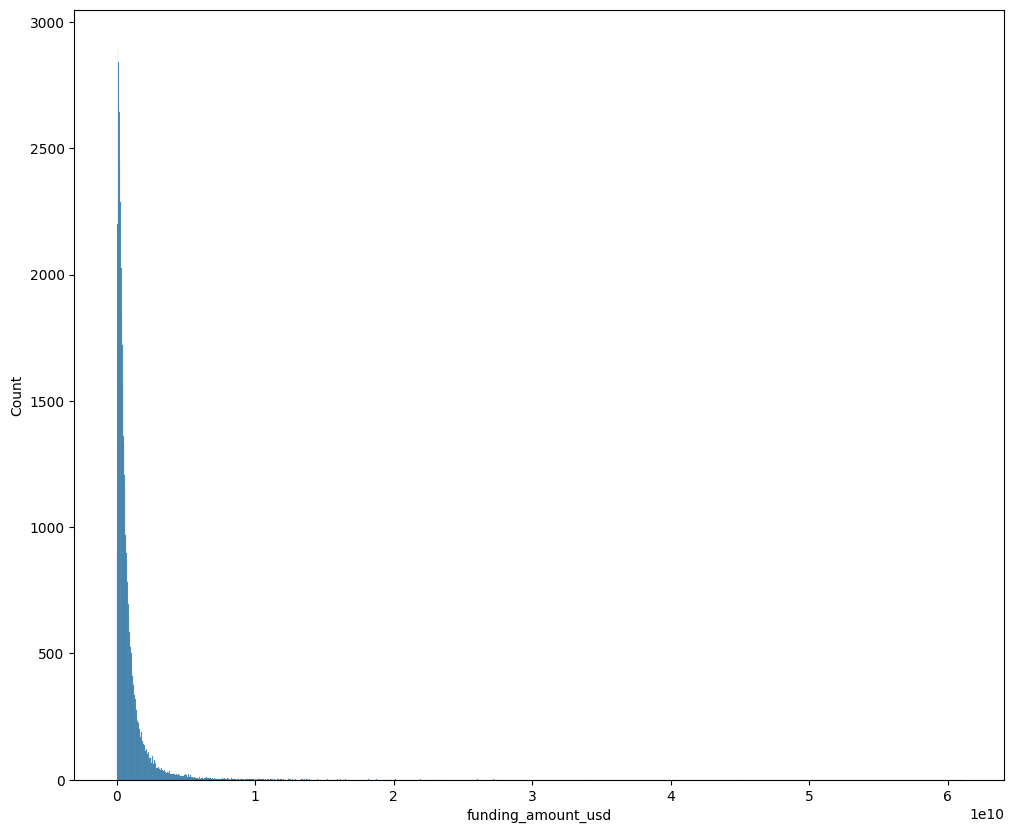

In [13]:
plt.figure(figsize=(12, 10))
sns.histplot(x='funding_amount_usd', data=df)
plt.show()


In [64]:
aliquota = df.sample(n=50, random_state=32)
aliquota.to_csv("aliquota_test.csv", index=False)

df_train = df.drop(aliquota.index).reset_index(drop=True)
df=df_train

In [31]:
df['exit_type_IPO'].value_counts()

exit_type_IPO
False    47422
True      2528
Name: count, dtype: int64

In [65]:
df.shape

(49950, 30)

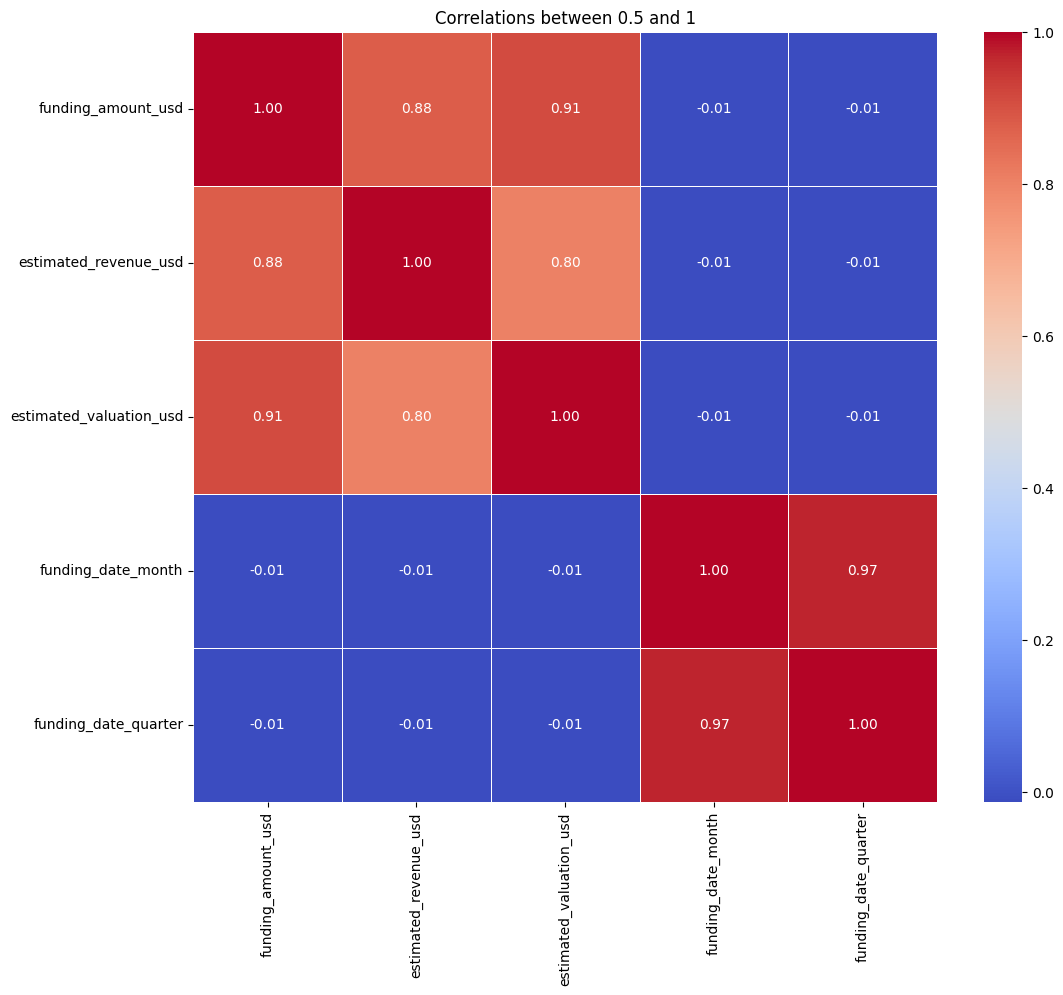

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular correlaciones
correlation_matrix = df.corr(numeric_only=True)

# Mantener solo correlaciones entre 0.5 y 1 (sin incluir 1)
mask = (correlation_matrix.abs() > 0.5) & (correlation_matrix.abs() < 1)

# Filtrar filas y columnas relevantes
strong_corr = correlation_matrix.loc[
    mask.any(axis=1),
    mask.any(axis=0)
]

# Graficar
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations between 0.5 and 1')
plt.show()





XGBoost Classifier

In [66]:
import pandas as pd
import random
import time
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

y = df['exit_type_IPO']  # target
X = df.drop('exit_type_IPO', axis=1)  # features

def test_model(clf, X_train, y_train, X_test, y_test, threshold=0.3):
    clf.fit(X_train, y_train)
    
    # Probabilidades de clase positiva
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Aplicar threshold
    y_pred = (y_proba >= threshold).astype(int)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_pos': f1_score(y_test, y_pred, pos_label=1, zero_division=0)  # F1 solo para IPO
    }, y_proba

# Función para buscar el mejor threshold
def find_best_threshold(y_true, y_proba):
    thresholds = np.arange(0.01, 1.0, 0.01)
    best_thresh = 0.5
    best_f1 = 0.0

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1_pos = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        if f1_pos > best_f1:
            best_f1 = f1_pos
            best_thresh = t
    return best_thresh, best_f1

results = []
start_total = time.time()

for i in range(1, 101):
    print(f"Ejecutando iteración {i}/100...")
    start_iter = time.time()

    e = random.randint(10, 300)   
    d = random.randint(3, 15)     
    r = random.randint(1, 300)    

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=r, stratify=y
    )
    original_distribution = dict(Counter(y_train))

    smote = SMOTE(random_state=r)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    res_distribution = dict(Counter(y_train_res))

    xgb_clf = XGBClassifier(
        n_estimators=e,
        max_depth=d,
        random_state=r,
        eval_metric='logloss',
        n_jobs=-1
    )

    metrics, y_proba = test_model(xgb_clf, X_train_res, y_train_res, X_test, y_test)

    # Buscar threshold óptimo para F1 de la clase positiva
    best_thresh, best_f1 = find_best_threshold(y_test, y_proba)

    results.append({
        'n_estimators': e,
        'max_depth': d,
        'random_state': r,
        'original_distribution': original_distribution,
        'resampled_distribution': res_distribution,
        'xgb_accuracy': metrics['accuracy'],
        'xgb_precision': metrics['precision'],
        'xgb_recall': metrics['recall'],
        'xgb_f1_score': metrics['f1_score'],
        'best_threshold': best_thresh,
        'best_f1_pos': best_f1
    })

    end_iter = time.time()
    print(f"Iteración {i} completada en {(end_iter - start_iter)/60:.2f} minutos.\n")

end_total = time.time()
print(f"Proceso completo en {(end_total - start_total)/60:.2f} minutos.")

results_df = pd.DataFrame(results)


Ejecutando iteración 1/100...
Iteración 1 completada en 0.02 minutos.

Ejecutando iteración 2/100...
Iteración 2 completada en 0.01 minutos.

Ejecutando iteración 3/100...
Iteración 3 completada en 0.01 minutos.

Ejecutando iteración 4/100...
Iteración 4 completada en 0.02 minutos.

Ejecutando iteración 5/100...
Iteración 5 completada en 0.01 minutos.

Ejecutando iteración 6/100...
Iteración 6 completada en 0.02 minutos.

Ejecutando iteración 7/100...
Iteración 7 completada en 0.01 minutos.

Ejecutando iteración 8/100...
Iteración 8 completada en 0.02 minutos.

Ejecutando iteración 9/100...
Iteración 9 completada en 0.02 minutos.

Ejecutando iteración 10/100...
Iteración 10 completada en 0.02 minutos.

Ejecutando iteración 11/100...
Iteración 11 completada en 0.01 minutos.

Ejecutando iteración 12/100...
Iteración 12 completada en 0.02 minutos.

Ejecutando iteración 13/100...
Iteración 13 completada en 0.02 minutos.

Ejecutando iteración 14/100...
Iteración 14 completada en 0.03 minuto

In [67]:
results_df.sort_values(by='xgb_accuracy',ascending=False).head(3)

,n_estimators,max_depth,random_state,original_distribution,resampled_distribution,xgb_accuracy,xgb_precision,xgb_recall,xgb_f1_score,best_threshold,best_f1_pos
69,255,7,157,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.932666,0.940586,0.932666,0.936303,0.01,0.519843
3,192,15,266,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.931198,0.939259,0.931198,0.934914,0.01,0.511039
29,113,15,29,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.931131,0.939868,0.931131,0.935130,0.01,0.525788


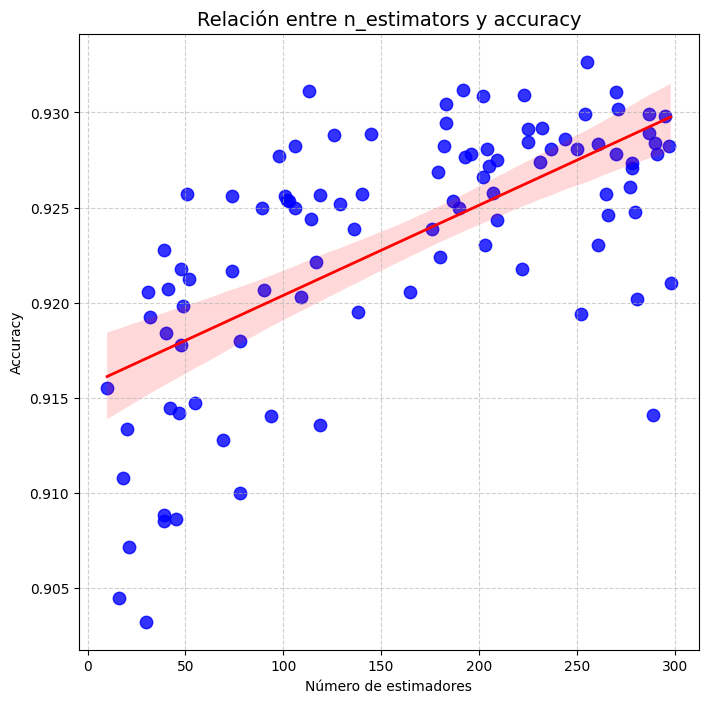

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.regplot(
    x="n_estimators", 
    y="xgb_accuracy", 
    data=results_df,
    scatter_kws={"s": 80, "color": "blue"},
    line_kws={"color": "red", "linewidth": 2}
)
plt.title("Relación entre n_estimators y accuracy", fontsize=14)
plt.xlabel("Número de estimadores")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Final model

In [77]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y = df['exit_type_IPO']  # target
X = df.drop('exit_type_IPO', axis=1)  # features

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=187, stratify=y
)

print("original distribution:", dict(Counter(y_train)))


smote = SMOTE(random_state=222)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("distribution after smote:", dict(Counter(y_train_res)))

# i use the best hyperparameters of my for loop model
model = XGBClassifier(
    n_estimators=256,
    max_depth=14,
    random_state=222,
    eval_metric='logloss',
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

# Predicciones probabilísticas
y_proba = model.predict_proba(X_test)[:, 1]

# Ajustar threshold
threshold = 0.15
y_pred = (y_proba >= threshold).astype(int)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))



original distribution: {False: 33195, True: 1770}
distribution after smote: {False: 33195, True: 33195}
Accuracy: 0.9251918585251918
Precision: 0.9462061260567619
Recall: 0.9251918585251918
F1: 0.9338874226891085

Classification report:
              precision    recall  f1-score   support

       False     0.9776    0.9428    0.9599     14227
        True     0.3565    0.5950    0.4459       758

    accuracy                         0.9252     14985
   macro avg     0.6671    0.7689    0.7029     14985
weighted avg     0.9462    0.9252    0.9339     14985



Now, we test the modulo with our aliquota 

In [78]:
df_test=pd.read_csv(r'C:\Users\alejo\Desktop\BYUI\CSE-310 LOCAL\CSE-310\personal-project\module-1-ML-PREAPPROVEDAPP\aliquota_test.csv')

df_test.shape


(50, 30)

In [49]:
df_test.head(4)

,founded_year,funding_amount_usd,employee_count,estimated_revenue_usd,estimated_valuation_usd,funding_date_day,funding_date_month,funding_date_year,funding_date_weekday,funding_date_quarter,co_investors_count,region_Europe,region_Latin America,region_MENA,region_North America,region_Oceania,industry_Blockchain,industry_E-commerce,industry_Fintech,industry_Healthcare,industry_Logistics,industry_SaaS,funding_round_Pre-Seed,funding_round_Seed,funding_round_Series A,funding_round_Series B,funding_round_Series C,funding_round_Series D,exit_type_IPO,exited_True
0,2012,5.504460e+08,833,2.242943e+08,4.976070e+09,7,6,2021,0,2,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
1,2018,1.126294e+10,859,1.953028e+09,6.333386e+10,19,11,2020,3,4,1,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,2023,2.000310e+08,257,3.930211e+07,8.970778e+08,22,8,2022,0,3,3,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,2007,1.536850e+08,77,5.027276e+07,1.103388e+09,28,5,2017,6,2,2,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,True


In [39]:
df_test.shape

(50, 30)

In [79]:
df_predicction=df_test.drop("exit_type_IPO", axis=1).values
new_pred = model.predict(df_predicction)

predictions = pd.DataFrame(new_pred, columns=['exit_type_IPO'])

predictions.to_csv("exit_type_IPO-predictions.csv", index=False)

checking predicctions

In [80]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_test['exit_type_IPO'], new_pred)

print("Accuracy:", accuracy)
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))





Accuracy: 0.96

Classification report:
              precision    recall  f1-score   support

       False     0.9776    0.9428    0.9599     14227
        True     0.3565    0.5950    0.4459       758

    accuracy                         0.9252     14985
   macro avg     0.6671    0.7689    0.7029     14985
weighted avg     0.9462    0.9252    0.9339     14985



In [81]:
model.save_model("investment-pred.json")
